# Машинное обучение: Задание 3

### Прогнозирование группы пользователей для осуществления таргетированной рекламы банковского продукта

### Описание проекта
Задача банка предложить потребительский кредит и при этом максимизировать [показатель конверсии](https://www.unisender.com/ru/support/about/glossary/chto-takoe-cr-conversion-rate/), который равен отношению количества пользователей, принявших кредит, к общему количеству пользователей, которым поступили предложения *(precision)*. Решение этой задачи актуально для банка, потому что это позволит сократить расходы на персональный маркетинг, но при этом достичь максимальной выгоды. Данный проект оптимизирует выбор кандидатов для персонального предложения о предоставлении кредита. В процесс отбора кандидатов можно внерить алгоритм отсева потенциальных кандидатов, готовых взять кредит. 

### Содержание 
+ [Использование результатов](#imports)
+ [Интерпретация модели](#feature_importance)
+ [Валидация и стабильность модели по фолдам](#validation)
+ [Оценка поведения модели](#model_behaviour)

In [26]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

# import custom classes for pipeline
from prep import FeatureGemerator, FeatureSelector, evaluate_economic_effect

<a id='imports'></a>
### Использование результатов
В этой секции будет рассмотрено использование готовой модели, пайплайна обработки данных и пайплайна обработки данных, совмещенного с моделью.

#### Описание данных
Описание датасета и EDA можно посмотреть в [предыдущем ноутбуке](Personal_Loan_project.ipynb#description_cell). Загрузим данные и разделим их на признаки ___X___ и целевую переменную ___y___.

In [27]:
# load_data 
df = pd.read_csv("BPL.csv")
df.sample(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
146,147,46,19,84,94102,1,2.67,2,0,0,0,0,1,1
3276,3277,55,31,159,92123,1,3.90,3,0,1,0,0,0,0
1070,1071,36,9,40,90840,2,1.00,2,0,0,0,0,1,0
3875,3876,26,2,119,95351,2,0.60,1,381,0,0,0,1,1
1782,1783,37,11,60,95825,2,2.80,1,181,0,0,0,0,1


In [28]:
# load grid_search results 
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.983,0.954023,0.864583,0.930079,0.907104
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
3,GradientBoostingClassifier,0.980,0.941860,0.843750,0.919110,0.890110


In [29]:
# train test split
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]

metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

#### Feature Engeneering Pipeline
Для создания новых и удаления неинформативных фичей создан пайплайн ___feature_engeneering_pipeline___. 

Пример использования:

In [30]:
# feature_engeneering_pipeline
feature_engeneering_pipeline = joblib.load('data_engeneering_pipeline.pkl')
feature_engeneering_pipeline.transform(X.head(1))

,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,IsMortgaged,IsFamily,IsEducated,IsMortgaged75,IsIncome75,IsCCAvg75
0,49,4,1.6,1,0,1,0,0,0,0,1,0,0,0,0


#### Model
Валидацию, поиск по сетке и выбор модели можно также посмотреть в [предыдущем ноутбуке](Personal_Loan_project.ipynb#model_cell). Далее будет рассмотрено использование модели для предсказания предобработанных ___feature_engeneering_pipeline___ данных.

In [31]:
# load model (cb_classifier)
cb_classifier = joblib.load('models\\cb_model.pkl')
cb_classifier

In [32]:
# making predictions
print(cb_classifier.predict(feature_engeneering_pipeline.transform(X.head(1))))

# predict proba
print(cb_classifier.predict_proba(feature_engeneering_pipeline.transform(X.head(1))))

[0]
[[9.99966897e-01 3.31031296e-05]]


#### Общий пайплайн
Для упрощения процесса получения предсказаний сделаем pipeline, объединяющий прерыдущие 2 этапа преобразования и вычисления результата в один.

In [33]:
# concat_pipeline
model_pipeline = Pipeline([
        ('feature_engeneering_pipeline', feature_engeneering_pipeline),
        ('cb_classifier', cb_classifier)
    ])

# saving pipeline
joblib.dump(model_pipeline, 'models\\final_model.pkl')

['models\\final_model.pkl']

In [34]:
# loading pipeline
model_pipeline = joblib.load('models\\final_model.pkl')

# making predictions with pipeilne
print(model_pipeline.predict(X.head(1)))

# predict proba with pipeline
print(model_pipeline.predict_proba(X.head(1)))

[0]
[[9.99966897e-01 3.31031296e-05]]


<a id='feature_importance'></a>
### Интерпретация модели
С помощью градиентного бустинка (в данном случае, CatBoostClassifier), можно получить ___feature_importance___ для понимания важности признаков модели.

In [35]:
# feature importance
feature_importance_df = cb_classifier.get_feature_importance(prettified=True)
very_important_features = feature_importance_df['Feature Id'][:4] # for future

feature_importance_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Feature Id,Income,Education,Family,CCAvg,IsEducated,Mortgage,CD Account,IsCCAvg75,IsIncome75,Online
Importances,25.173,17.3299,17.021,16.327,6.98986,3.20094,3.19656,2.72506,2.47061,2.40087


Самыми влиятельными признаками являются Income, Education, Family и CCAvg, что является довольно логичным с точки зрения банка. Занесем их в ___very_important_features___.

<a id='validation'></a>
### Валидация и стабильность модели по фолдам
Для оценки качества модели мы использовали стратифицированную ___k-Fold___ валидацию на всем датасете с разбиением на 11 фолдов. Это позволит более точно оценить качество стандартное отклонение качества модели на различных данных.


In [36]:
%%time 

# stratified StratifiedKFold
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=RANDOM_STATE)

# scores
scoring = list(scoring_df.columns)[1:]
# print(f'Scoring columns: {scoring}')

scores = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
scores.keys()

Wall time: 2min 33s


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc', 'test_f1'])

In [37]:
# cv_scores to dateframe
model_cv_scores = pd.DataFrame()
model_cv_scores['fold'] = np.arange(1, 12)

for score in scores:
    if 'test_' in score:
        model_cv_scores[score] = scores[score]
        
model_cv_scores

,fold,test_accuracy,test_precision,test_recall,test_roc_auc,test_f1
0,1,0.989011,1.000000,0.886364,0.997678,0.939759
1,2,0.989011,1.000000,0.886364,0.993917,0.939759
2,3,0.986813,0.952381,0.909091,0.997788,0.930233
3,4,0.984615,0.974359,0.863636,0.998507,0.915663
4,5,0.984615,0.930233,0.909091,0.997678,0.919540
5,6,0.993407,1.000000,0.931818,0.998949,0.964706
6,7,0.984581,0.950000,0.883721,0.998246,0.915663
7,8,0.995595,0.955556,1.000000,0.999830,0.977273
8,9,0.986784,1.000000,0.860465,0.997397,0.925000
9,10,0.991189,1.000000,0.906977,0.999378,0.951220


В предыдущем задании мы [поставили задачу](Personal_Loan_project.ipynb#buisness_and_math_task) решения задачи оптимизации с максимизацией ___f1_score___. Из результатов валидации видно, что некоторые метрики ведут себя не очень стабильно на разных фолдах. Визуализируем это и посчитаем их среднее квадратичное отклонение ___std___ по фолдам.

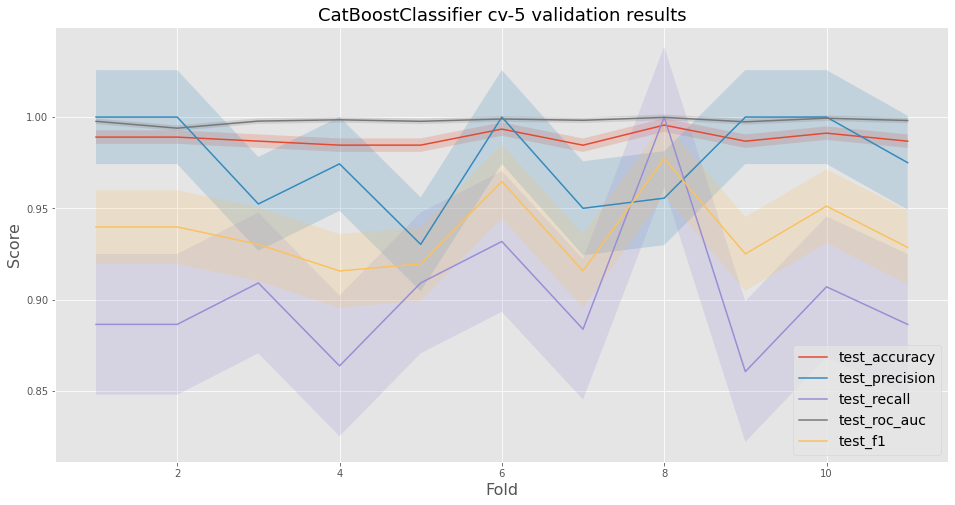

In [38]:
# vizualization
std_coef = 1.

plt.figure(figsize=(16, 8))

for column in model_cv_scores:
    if column != 'fold':
        plt.plot(model_cv_scores['fold'], model_cv_scores[column], label=column)
        plt.fill_between(x=model_cv_scores['fold'], 
                         y1=model_cv_scores[column]+std_coef*model_cv_scores[column].std(),
                         y2=model_cv_scores[column]-std_coef*model_cv_scores[column].std(),
                         alpha=.2)
        
        
plt.title('CatBoostClassifier cv-5 validation results', size=18)
plt.xlabel('Fold', size=16)
plt.ylabel('Score', size=16)

plt.legend(loc='lower right', fontsize=14);

In [39]:
model_cv_scores.loc[:, 'test_accuracy':].std()

test_accuracy     0.003692
test_precision    0.025749
test_recall       0.038578
test_roc_auc      0.001541
test_f1           0.020207
dtype: float64

Модель имеет довольно большой разброс в качестве предсказания по фолдам: стандатное отклонение по f1_score - 0.02 или 2%. Посчитаем экономический эффект от разброса на одно ___std___ с одного пользователя (n=1) при выгоде с тарифа M=1000р. и издержках на предложение N=50р.

In [40]:
delta = evaluate_economic_effect(score=0.02, N=50, n=1, M=1000)
delta

-30.0

<a id='model_behaviour'></a>
### Оценка поведения модели
#### Дисбаланс классов
Оценим качество предсказаний модели при сильном смещении распределения классов. Для этого возьмем два крайних варианта - предсказание всех объектов с целевой переменной 0 и всех объектов с целевой переменной 1.

In [41]:
X_only_true = X[(y == 1).values]
X_only_false = X[(y == 0).values]

preds_only_true = model_pipeline.predict(X_only_true)
preds_only_false = model_pipeline.predict(X_only_false)

1 - preds_only_false.mean(), preds_only_true.mean()

(0.9988938053097345, 0.9604166666666667)

Модели градиентного бустинга являются довольно устойчивыми к изменению распределения целевой переменной, поэтому наша модель показала высокую точность на предсказании по датасету с единственным классом.

#### Уязвимые места модели
Для того, чтобы найти уязвимые места модели, посмотрим на данные в которых модель выдает неправильные ответы.

In [42]:
# find out missing values
df['preds'] = model_pipeline.predict(X)
df['correct'] = df['preds'] == df['Personal Loan']
df['correct'].mean()

wa = df[df['correct'] == 0] # wrong answers
ta = df[df['correct'] == 1] # true answers

wa.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,preds,correct
12,13,48,23,114,93106,2,3.8,3,0,0,1,0,0,0,1,False
261,262,42,16,111,93106,2,1.2,3,251,1,0,0,1,0,0,False
323,324,59,34,99,90034,1,4.4,1,0,1,0,0,0,0,0,False
464,465,43,19,83,94305,4,3.6,3,0,1,0,0,0,1,0,False
505,506,36,12,69,94305,3,3.1,2,0,1,0,0,1,0,0,False


In [43]:
wa.describe().loc[:, very_important_features]

,Income,Education,Family,CCAvg
count,24.00000,24.00000,24.000000,24.000000
mean,104.62500,2.37500,2.458333,2.587500
std,11.77622,0.76967,1.284664,1.283783
min,69.00000,1.00000,1.000000,0.500000
25%,100.50000,2.00000,1.000000,1.500000
50%,109.00000,3.00000,2.000000,2.500000
75%,113.00000,3.00000,4.000000,3.800000
max,115.00000,3.00000,4.000000,4.600000


In [44]:
ta.describe().loc[: , very_important_features]

,Income,Education,Family,CCAvg
count,4976.000000,4976.000000,4976.000000,4976.000000
mean,73.625402,1.878617,2.396101,1.934805
std,46.087659,0.839560,1.147099,1.749109
min,8.000000,1.000000,1.000000,0.000000
25%,39.000000,1.000000,1.000000,0.700000
50%,63.000000,2.000000,2.000000,1.500000
75%,98.000000,3.000000,3.000000,2.500000
max,224.000000,3.000000,4.000000,10.000000


Из статистик по четырем главным фичам становится понятно, что диапазон ошибок модели довольно узок. Следовательно, можно предположить что модель ошибается на каком-то определенном диапазоне данных. Посмотрим теперь на графическую визуализацию распределения ошибок модели по 4м главным признакам.

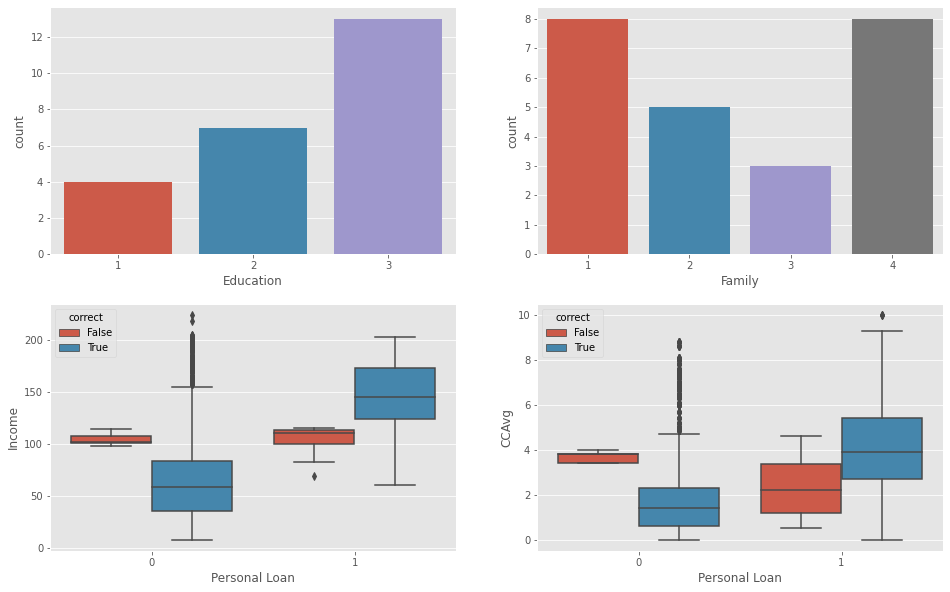

In [45]:
_, ax = plt.subplots(2, 2, figsize=(16, 10))

# contplots for cat features
sns.countplot('Education', data=wa, ax=ax[0, 0])
sns.countplot('Family', data=wa, ax=ax[0, 1])

# boxplots for num features
sns.boxplot(x='Personal Loan', y='Income', data=df, hue='correct', ax=ax[1, 0])
sns.boxplot(x='Personal Loan', y='CCAvg', data=df, hue='correct', ax=ax[1, 1]);


Для визуализации распределения ошибок по категориальным признакам были использованы столбчатые диаграммы. В связи с малым количеством ошибок по всей выборке (24 шт), тяжело судить о равномерности / неравномерности распределения ошибок по классам. Однако, для номенативных признаков становится довольно очевидно, что модель ошибается на области разделения данных. Это может означать, что: 
* Для безошибочного разделения данных модели не хватает других весомых признаков.
* Все ошибки будут сопроваждаться низким уровнем уверенности моели в ответах (model confidence).

Из второго пункта было решено показывать в демо-стенде confidence level для возможной ручной разметки данных банковскими сотрудниками в уязвимых местах.  

Из написанного выше можно сделать вывод, что модель будет работать лучше всего, и иметь высокую степень уверенности ___model_confidence___ на крайних людях, имеющих либо очень "хорошие", либо очень "плохие" показатели по всем главным признакам: ___Income___, ___Family___, ___Education___, ___CCAvg___.